## Thermostat 2.0 : Simulation on previous year SSH data 
1. To test performance of new Thermostat 2.0 on previous Thermostat execution in AHU's. Different configurations will be fed to test the performance of current design.
2. For simulating on the previous dataset, we will have to assume a particular rate of error correction on the area temperature for change in actuator position while simulating the new outputs given by the new Thermostat.

In [41]:
import mpld3
mpld3.enable_notebook()

In [2]:
import ab
import pandas as pd
import matplotlib
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.tree import DecisionTreeRegressor

from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
def create_corr_heatmap(dataframe):
    '''
        Input DataFrame
    '''
    dataframe = dataframe.replace(to_replace='null',value=np.nan)
    dataframe = dataframe.dropna()
    dataframe = dataframe.fillna(0)

    col = list(dataframe.columns)
    dataframe = dataframe.astype(float, errors="ignore")

    corr = dataframe.corr()
    
    highly_corellated = corr.unstack()
    highly_corellated = highly_corellated.drop_duplicates().sort_values(kind = 'quicksort', ascending=False)
    highly_corellated = highly_corellated.to_frame()
    highly_corellated.reset_index(inplace=True)
    highly_corellated.columns = ['Param1','Param2','Value']
    highly_corellated = highly_corellated.loc[(highly_corellated['Value'] > 0.2) & (highly_corellated['Value'] < 0.95)]

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
   
    f, ax = plt.subplots(figsize=(30, 25))
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.6, cbar_kws={"shrink": .5})
    return highly_corellated

In [4]:
parameterConfig = {"actionableMax": 95, "actionableMin": 60,"controllSpeed": 1, "timeToAchieveSetpoint": 60,"degreeOfFreedom": 5,"setpoint": 25,"controllerDirection": 1, "sampleTime": 2}

In [5]:
data1 = pd.read_csv("PID-Info-2018-08-11.csv")
data2 = pd.read_csv("PID-Info-2018-08-12.csv")
data3 = pd.read_csv("PID-Info-2018-08-13.csv")
data4 = pd.read_csv("PID-Info-2018-08-14.csv")

In [6]:
data = pd.concat([data1, data2, data3, data4], axis = 0)

In [7]:
data.shape

(4570, 10)

In [8]:
# data = data.drop(data[(data['AHU OPERATIONAL STATUS'] == 'off') | (data['ACTUATOR OUTPUT'] < 50) | (data['ACTUATOR FEEDBACK'] < 50)].index)
# data.head()
data = data.drop(data[data['AHU OPERATIONAL STATUS'] == 'off'].index)
data = data.dropna()

In [9]:
data.head()

,TIME STAMP,SET POINT,OFFSET,MISSING DATA POINTS,AREA TEMPERATURE,AHU OPERATIONAL STATUS,ACTUATOR OUTPUT,ACTUATOR FEEDBACK,VFD OUTPUT,VFD FEEDBACK
35,2018-08-11 00:36:21,24.5,0.5,0,24.00,on,10,11,33,33.0
36,2018-08-11 00:37:23,24.5,0.5,0,24.05,on,10,11,33,33.0
37,2018-08-11 00:38:25,24.5,0.5,0,24.10,on,10,11,33,33.0
38,2018-08-11 00:39:27,24.5,0.5,0,24.16,on,10,11,33,33.0
39,2018-08-11 00:40:29,24.5,0.5,0,24.21,on,10,11,33,33.0


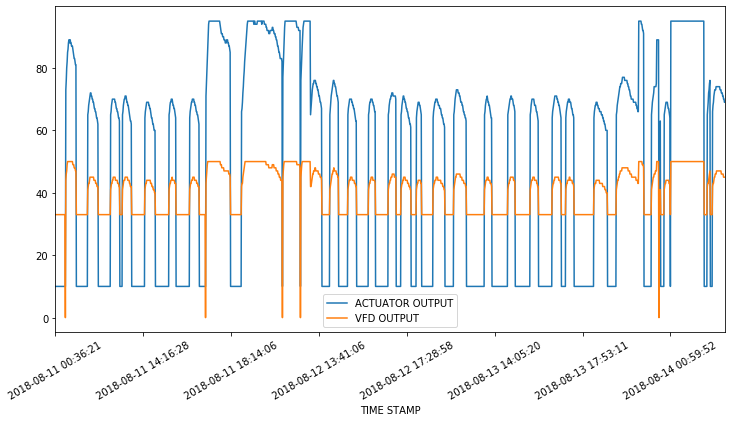

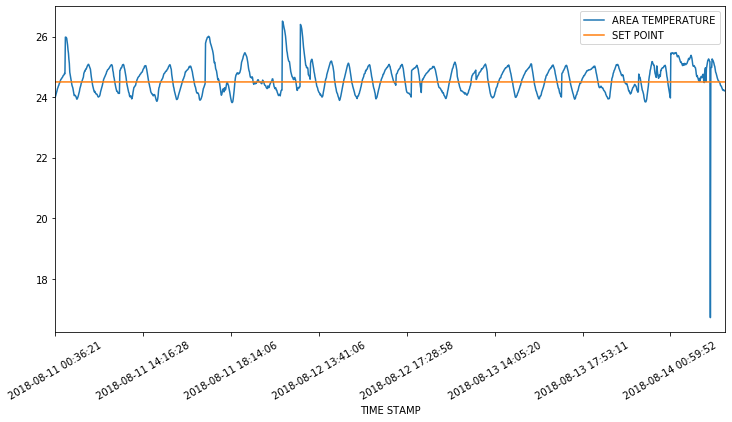

In [10]:
data.plot(x = 'TIME STAMP', y=['ACTUATOR OUTPUT', 'VFD OUTPUT'],figsize=(12, 6), rot = 30)
plt.show()
data.plot(x = 'TIME STAMP', y=["AREA TEMPERATURE", "SET POINT"], figsize=(12, 6), rot = 30)
plt.show()

## Try to fit linear model on *vfd ouput* and *actuator output* to predict *Area-Temp*

In [11]:
X = data[["ACTUATOR OUTPUT", "VFD OUTPUT"]].values
Y = data["AREA TEMPERATURE"].values

In [12]:
X_Scaler = StandardScaler().fit(X)
Y_Scaler = StandardScaler().fit(Y.reshape(-1, 1))

In [13]:
X = X_Scaler.transform(X)
Y = Y_Scaler.transform(Y.reshape(-1, 1))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [15]:
params = {'n_estimators': 9999, 'max_depth': 20, 'min_samples_split': 5,
          'learning_rate': 0.02, 'loss': 'ls', 'verbose': 0}
reg = ensemble.GradientBoostingRegressor(**params)

In [16]:
reg.fit(X_train, y_train)

/home/utkarshmalik/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.02, loss='ls', max_depth=20,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=9999,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
preds = reg.predict(X_test)

In [21]:
results = pd.DataFrame({
    "preds": Y_Scaler.inverse_transform(preds ).flatten(),
    "orig":  Y_Scaler.inverse_transform(y_test).flatten()
})

#### MSE
``` Good enough```

In [23]:
error = results["orig"] - results["preds"]
error = (error ** 2).sum()/len(error)
error

0.10268993994848995

### ABcontroller 

In [24]:
contAB = ab.AB(parameterConfig)

In [25]:
contAB.compute(22)

Error -->
3
29


67.07976190476191

### Simulate AbController on Past Data

In [26]:
testData = data1
# testData = testData.drop(testData[(testData['AHU OPERATIONAL STATUS'] == 'off') | (testData['ACTUATOR OUTPUT'] < 50) | (testData['ACTUATOR FEEDBACK'] < 50)].index)

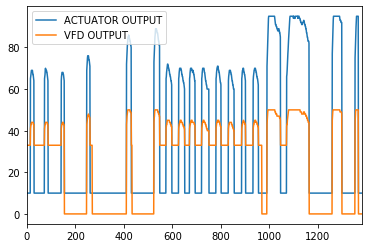

In [27]:
testData[["ACTUATOR OUTPUT", "VFD OUTPUT"]].plot()

In [60]:
vfdParameterConfig = {
    "actionableMax": 50,
    "actionableMin": 30,
    "controllSpeed": 3,
    "timeToAchieveSetpoint": 60,
    "degreeOfFreedom": 5,
    "setpoint": 24.5,
    "controllerDirection": 1,
    "sampleTime": 1
}
actuatorParameterConfig = {
    "actionableMax": 95,
    "actionableMin": 60,
    "controllSpeed": 3,
    "timeToAchieveSetpoint": 60,
    "degreeOfFreedom": 5,
    "setpoint": 24.5,
    "controllerDirection": 1,
    "sampleTime": 1
}

In [61]:
vfdController = ab.AB(vfdParameterConfig)
actuatorController = ab.AB(actuatorParameterConfig)

In [62]:
X.shape

(1525, 2)

In [63]:
Y_Scaler.inverse_transform(reg.predict(X_Scaler.transform(np.array([10, 20]).reshape(1, -1))))

array([24.53532258])

In [64]:
prevActuator = 0

In [65]:
results = []
newTemp = 0
for index, row in testData.iterrows():
    
    actuator, vfd, temp = row["ACTUATOR OUTPUT"], row["VFD OUTPUT"], row["AREA TEMPERATURE"]
    if (actuator - prevActuator) > 30 :
        vfdController = ab.AB(vfdParameterConfig)
        actuatorController = ab.AB(actuatorParameterConfig)
    prevActuator = actuator
    newActuator, newVfd = actuatorController.compute(newTemp), vfdController.compute(newTemp),
    regInput =  X_Scaler.transform(np.array([newActuator, newVfd]).reshape(1, -1))
    regOutput = Y_Scaler.inverse_transform(reg.predict(regInput))
    newTemp = regOutput[0]
    output = {
        "originalTemp": temp,
        "newTemp": regOutput[0],
        "originalActuator": actuator,
        "newActuator": newActuator,
        "originalVfd" : vfd,
        "newVfd": newVfd
    }
    results.append(output)

Error -->
24.5
59
Error -->
24.5
59
Error -->
0.2690749081063615
58
Error -->
0.2690749081063615
58
Error -->
0.2690749081063615
57
Error -->
0.2690749081063615
57
Error -->
0.2690749081063615
56
Error -->
0.2690749081063615
56
Error -->
0.2690749081063615
55
Error -->
0.2690749081063615
55
Error -->
0.2691031307284639
54
Error -->
0.2691031307284639
54
Error -->
0.2691031307284639
53
Error -->
0.2691031307284639
53
Error -->
0.2691031307284639
52
Error -->
0.2691031307284639
52
Error -->
0.2691031307284639
51
Error -->
0.2691031307284639
51
Error -->
0.2691031307284639
50
Error -->
0.2691031307284639
50
Error -->
0.2691031307284639
49
Error -->
0.2691031307284639
49
Error -->
0.2691031307284639
48
Error -->
0.2691031307284639
48
Error -->
0.2691031307284639
47
Error -->
0.2691031307284639
47
Error -->
0.2691031307284639
46
Error -->
0.2691031307284639
46
Error -->
0.3150000000000013
45
Error -->
0.3150000000000013
45
Error -->
0.3150000000000013
59
Error -->
0.3150000000000013
59
Erro

Error -->
0.2690749081063615
56
Error -->
0.2690749081063615
56
Error -->
0.2690749081063615
55
Error -->
0.2690749081063615
55
Error -->
0.2691031307284639
54
Error -->
0.2691031307284639
54
Error -->
0.2691031307284639
53
Error -->
0.2691031307284639
53
Error -->
0.2691031307284639
52
Error -->
0.2691031307284639
52
Error -->
0.2691031307284639
51
Error -->
0.2691031307284639
51
Error -->
0.2691031307284639
50
Error -->
0.2691031307284639
50
Error -->
0.2691031307284639
49
Error -->
0.2691031307284639
49
Error -->
0.2691031307284639
48
Error -->
0.2691031307284639
48
Error -->
0.2691031307284639
47
Error -->
0.2691031307284639
47
Error -->
0.2691031307284639
46
Error -->
0.2691031307284639
46
Error -->
0.3150000000000013
45
Error -->
0.3150000000000013
45
Error -->
0.3150000000000013
44
Error -->
0.3150000000000013
44
Error -->
0.3150000000000013
43
Error -->
0.3150000000000013
43
Error -->
0.3150000000000013
42
Error -->
0.3150000000000013
42
Error -->
0.3150000000000013
41
Error --

Error -->
-0.4823636363636332
13
Error -->
-0.4823636363636332
13
Error -->
-0.4823636363636332
12
Error -->
-0.4823636363636332
12
Error -->
-0.4823636363636332
11
Error -->
-0.4823636363636332
11
Error -->
-0.4823636363636332
10
Error -->
-0.4823636363636332
10
Error -->
-0.4823636363636332
9
Error -->
-0.4823636363636332
9
Error -->
-0.4823636363636332
8
Error -->
-0.4823636363636332
8
Error -->
-0.4823636363636332
7
Error -->
-0.4823636363636332
7
Error -->
-0.4823636363636332
6
Error -->
-0.4823636363636332
6
Error -->
-0.4823636363636332
5
Error -->
-0.4823636363636332
5
Error -->
-0.4823636363636332
4
Error -->
-0.4823636363636332
4
Error -->
-0.4823636363636332
3
Error -->
-0.4823636363636332
3
Error -->
-0.4823636363636332
2
Error -->
-0.4823636363636332
2
Error -->
-0.4823636363636332
1
Error -->
-0.4823636363636332
1
Error -->
-0.4823636363636332
0
Error -->
-0.4823636363636332
0
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error 

Error -->
-0.5599999999999987
23
Error -->
-0.5599999999999987
23
Error -->
-0.5599999999999987
22
Error -->
-0.5599999999999987
22
Error -->
-0.5599999999999987
21
Error -->
-0.5599999999999987
21
Error -->
-1.2766666666666602
20
Error -->
-1.2766666666666602
20
Error -->
-1.2766666666666602
19
Error -->
-1.2766666666666602
19
Error -->
-0.8200000000000038
18
Error -->
-0.8200000000000038
18
Error -->
-0.4823636363636332
17
Error -->
-0.4823636363636332
17
Error -->
-0.4823636363636332
16
Error -->
-0.4823636363636332
16
Error -->
-0.4823636363636332
15
Error -->
-0.4823636363636332
15
Error -->
-0.4823636363636332
14
Error -->
-0.4823636363636332
14
Error -->
-0.4823636363636332
13
Error -->
-0.4823636363636332
13
Error -->
-0.4823636363636332
12
Error -->
-0.4823636363636332
12
Error -->
-0.4823636363636332
11
Error -->
-0.4823636363636332
11
Error -->
-0.4823636363636332
10
Error -->
-0.4823636363636332
10
Error -->
-0.4823636363636332
9
Error -->
-0.4823636363636332
9
Error -->
-0

Error -->
0.4374418832373834
31
Error -->
0.4374418832373834
31
Error -->
0.4086321772285473
30
Error -->
0.4086321772285473
30
Error -->
0.40860162057603233
29
Error -->
0.40860162057603233
29
Error -->
0.20001318429116566
28
Error -->
0.20001318429116566
28
Error -->
-0.5640000000000001
27
Error -->
-0.5640000000000001
27
Error -->
-0.9199999999999982
26
Error -->
-0.9199999999999982
26
Error -->
-0.5640000000000001
25
Error -->
-0.5640000000000001
25
Error -->
-0.35249999999999915
24
Error -->
-0.35249999999999915
24
Error -->
-0.5599999999999987
23
Error -->
-0.5599999999999987
23
Error -->
-0.5599999999999987
22
Error -->
-0.5599999999999987
22
Error -->
-0.5599999999999987
21
Error -->
-0.5599999999999987
21
Error -->
-1.2766666666666602
20
Error -->
-1.2766666666666602
20
Error -->
-1.2766666666666602
19
Error -->
-1.2766666666666602
19
Error -->
-0.8200000000000038
18
Error -->
-0.8200000000000038
18
Error -->
-0.4823636363636332
17
Error -->
-0.4823636363636332
17
Error -->
-0

Error -->
-0.5640000000000001
27
Error -->
-0.5640000000000001
27
Error -->
-0.9199999999999982
26
Error -->
-0.9199999999999982
26
Error -->
-0.5640000000000001
25
Error -->
-0.5640000000000001
25
Error -->
-0.35249999999999915
24
Error -->
-0.35249999999999915
24
Error -->
-0.5599999999999987
23
Error -->
-0.5599999999999987
23
Error -->
-0.5599999999999987
22
Error -->
-0.5599999999999987
22
Error -->
-0.5599999999999987
21
Error -->
-0.5599999999999987
21
Error -->
-1.2766666666666602
20
Error -->
-1.2766666666666602
20
Error -->
-1.2766666666666602
19
Error -->
-1.2766666666666602
19
Error -->
-0.8200000000000038
18
Error -->
-0.8200000000000038
18
Error -->
-0.4823636363636332
17
Error -->
-0.4823636363636332
17
Error -->
-0.4823636363636332
16
Error -->
-0.4823636363636332
16
Error -->
-0.4823636363636332
15
Error -->
-0.4823636363636332
15
Error -->
-0.4823636363636332
14
Error -->
-0.4823636363636332
14
Error -->
-0.4823636363636332
13
Error -->
-0.4823636363636332
13
Error --

Error -->
0.3150000000000013
41
Error -->
0.3150000000000013
41
Error -->
0.3150000000000013
40
Error -->
0.3150000000000013
40
Error -->
0.4300000000000068
39
Error -->
0.4300000000000068
39
Error -->
0.4300000000000068
38
Error -->
0.4300000000000068
38
Error -->
0.4300000000000068
37
Error -->
0.4300000000000068
37
Error -->
0.4300000000000068
36
Error -->
0.4300000000000068
36
Error -->
0.4300000000000068
35
Error -->
0.4300000000000068
35
Error -->
0.4399999999999977
34
Error -->
0.4399999999999977
34
Error -->
0.4399999999999977
33
Error -->
0.4399999999999977
33
Error -->
0.4399999999999977
32
Error -->
0.4399999999999977
32
Error -->
0.4374418832373834
31
Error -->
0.4374418832373834
31
Error -->
0.4086321772285473
30
Error -->
0.4086321772285473
30
Error -->
0.40860162057603233
29
Error -->
0.40860162057603233
29
Error -->
0.20001318429116566
28
Error -->
0.20001318429116566
28
Error -->
-0.5640000000000001
27
Error -->
-0.5640000000000001
27
Error -->
-0.9199999999999982
26
E

Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->


Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->
-0.4823636363636332
Error -->


Error -->
0.2691031307284639
48
Error -->
0.2691031307284639
48
Error -->
0.2691031307284639
47
Error -->
0.2691031307284639
47
Error -->
0.2691031307284639
46
Error -->
0.2691031307284639
46
Error -->
0.3150000000000013
45
Error -->
0.3150000000000013
45
Error -->
0.3150000000000013
44
Error -->
0.3150000000000013
44
Error -->
0.3150000000000013
43
Error -->
0.3150000000000013
43
Error -->
0.3150000000000013
42
Error -->
0.3150000000000013
42
Error -->
0.3150000000000013
41
Error -->
0.3150000000000013
41
Error -->
0.3150000000000013
40
Error -->
0.3150000000000013
40
Error -->
0.4300000000000068
39
Error -->
0.4300000000000068
39
Error -->
0.4300000000000068
38
Error -->
0.4300000000000068
38
Error -->
0.4300000000000068
37
Error -->
0.4300000000000068
37
Error -->
0.4300000000000068
36
Error -->
0.4300000000000068
36
Error -->
0.4300000000000068
35
Error -->
0.4300000000000068
35
Error -->
0.4399999999999977
34
Error -->
0.4399999999999977
34
Error -->
0.4399999999999977
33
Error --

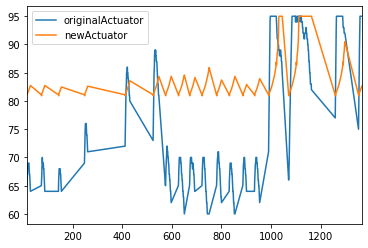

In [66]:
results = pd.DataFrame(results)
results[results["originalActuator"] > 50][["originalActuator", "newActuator"]].plot()

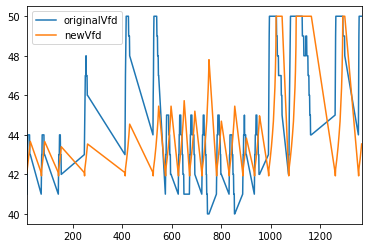

In [67]:
results[results["originalActuator"] > 50][["originalVfd", "newVfd"]].plot()

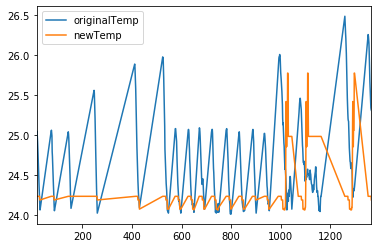

In [68]:
results[results["originalActuator"] > 50][["originalTemp", "newTemp"]].plot()